In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [22]:
# Function to generate image pairs
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)

    return np.array(pair_images), np.array(pair_labels)

In [23]:
!gdown --id 15M5INfetEVF4XVXSGVyU5vnMlEoe9Bo4

!gdown --id 1NTVirb1NyniG_XumTGQK6L5ATOKuz1t6


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15M5INfetEVF4XVXSGVyU5vnMlEoe9Bo4
To: /content/olivetti_faces.npy
100% 6.55M/6.55M [00:00<00:00, 43.1MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1NTVirb1NyniG_XumTGQK6L5ATOKuz1t6
To: /content/olivetti_faces_target.npy
100% 1.68k/1.68k [00:00<00:00, 7.93MB/s]


In [24]:


# Get the data directory paths
faces = '/content/olivetti_faces.npy'
faces_targets = '/content/olivetti_faces_target.npy'



In [25]:
# Load the images and labels

face_labels = np.load(faces_targets)
face_images = np.load(faces)

In [26]:
target_shape = face_images[0].shape

In [27]:
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

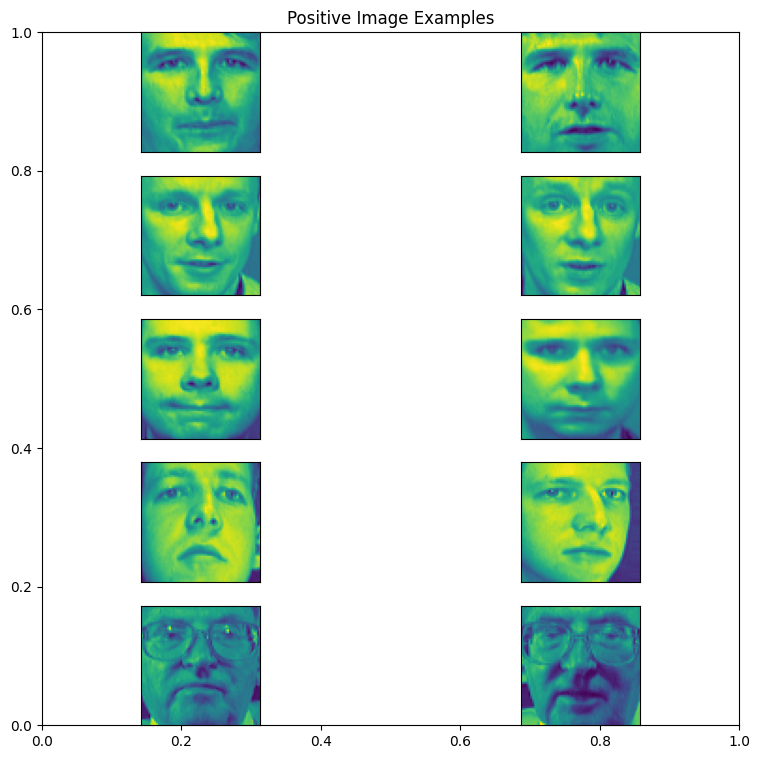

In [28]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

# Visualize Positive Images
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")


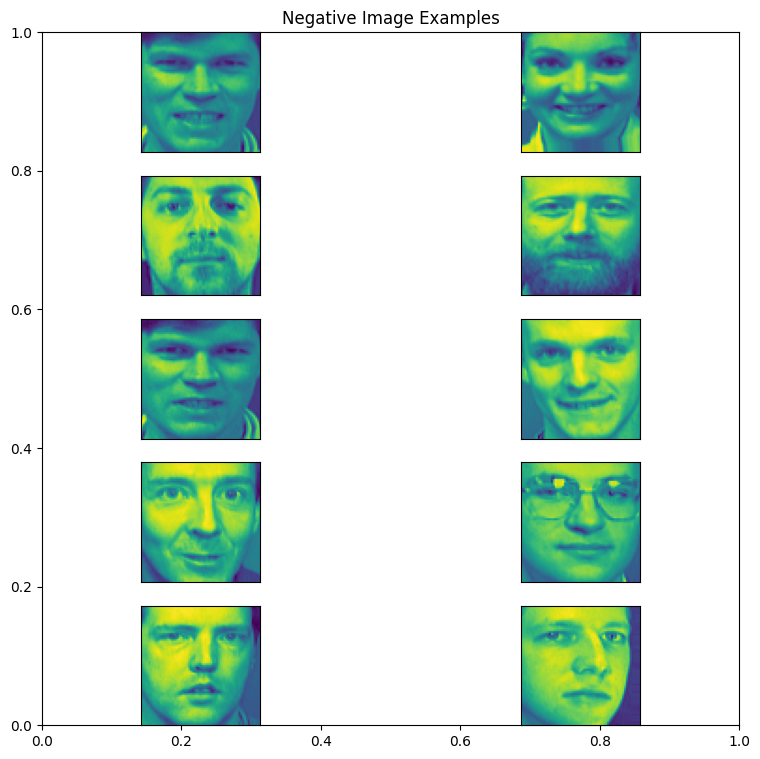

In [29]:
# Visualize Negative Images
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

In [30]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

In [31]:
import tensorflow.keras.backend as K

In [32]:
# Define the Contrastive Loss
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss


In [33]:
# Distance Layer
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [34]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)


In [35]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)


Epoch 1/150
10/10 [==============================] - 4s 157ms/step - loss: 0.6571 - accuracy: 0.5063 - val_loss: 0.6491 - val_accuracy: 0.5500
Epoch 2/150
10/10 [==============================] - 1s 124ms/step - loss: 0.6247 - accuracy: 0.5063 - val_loss: 0.6198 - val_accuracy: 0.5375
Epoch 3/150
10/10 [==============================] - 1s 122ms/step - loss: 0.6152 - accuracy: 0.5078 - val_loss: 0.5933 - val_accuracy: 0.5375
Epoch 4/150
10/10 [==============================] - 1s 122ms/step - loss: 0.6102 - accuracy: 0.5125 - val_loss: 0.5925 - val_accuracy: 0.5437
Epoch 5/150
10/10 [==============================] - 1s 122ms/step - loss: 0.6131 - accuracy: 0.5063 - val_loss: 0.6019 - val_accuracy: 0.5437
Epoch 6/150
10/10 [==============================] - 1s 124ms/step - loss: 0.6039 - accuracy: 0.5203 - val_loss: 0.6175 - val_accuracy: 0.5938
Epoch 7/150
10/10 [==============================] - 1s 134ms/step - loss: 0.6040 - accuracy: 0.5219 - val_loss: 0.6123 - val_accuracy: 0.6375

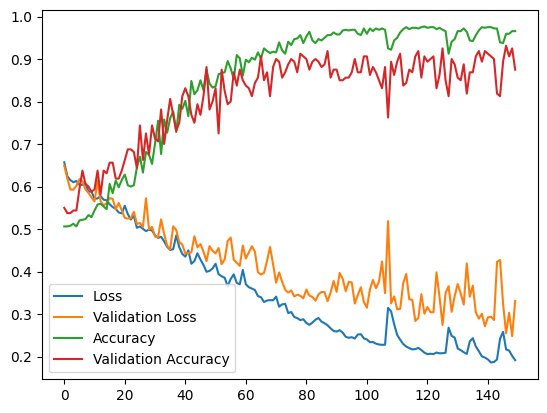

In [36]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])


In [37]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

Test1

In [38]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

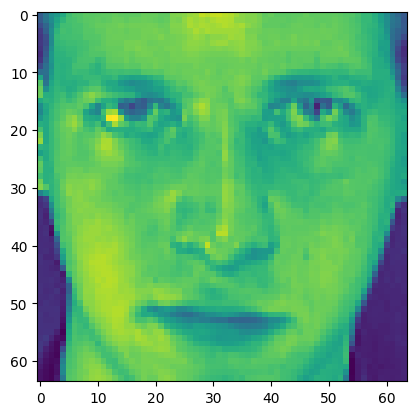

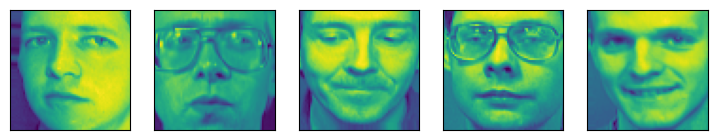

In [39]:
plt.imshow(test_image)



test_visualize(compare_images)



In [40]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))

image_pairs = np.array(image_pairs)

In [41]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

print(score)

1/1 [==============================] - 1s 569ms/step
[[0.78123444]
 [0.13093826]
 [0.00473437]
 [0.00156139]
 [0.00155045]]


Test2

In [68]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(210, 220), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range((i +1) * 10, (i + 34) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

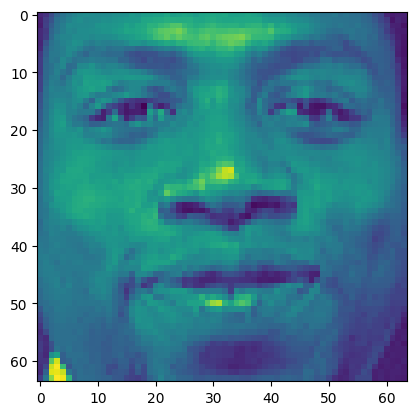

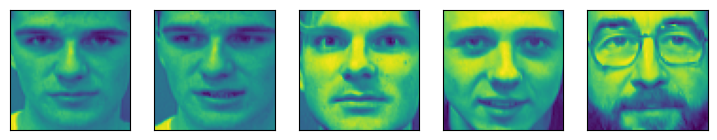

In [69]:
plt.imshow(test_image)



test_visualize(compare_images)



In [70]:


image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))

image_pairs = np.array(image_pairs)



In [71]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

print(score)

1/1 [==============================] - 0s 19ms/step
[[0.01509328]
 [0.01493523]
 [0.01071983]
 [0.00046161]
 [0.00362867]]
